# A. Importing standard libraries and user-defined libraries

In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

import a_matrix_analysis_lib as mat_ansys
import b_spin_representations as su2
import c_evs_visualization_tools as evs_visz_tools
import d_projected_evolution_dynamics as me
import e_Multiple_Max_Ent_evs as HBProjEv

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

# B. Defining the system

## 1. Ferromagnetic XX-model's Hamiltonian

We start by considering a ferromagnetic XX-Heisenberg-like six-site lattice, with closed boundary conditions, acting on the system's Hilbert space,  $\bigotimes_{i=1}^{N=6}{\bf C}^2$.

In order to do that, we invoke *b_spin_representations'* s module "one_body_spin_ops" which constructs the appropiate local one-body Pauli operators acting on the full Hilbert's space, i.e.

$$
    {\bf S}_{{x,y,z}}^{j} = \textrm{id}_2 \otimes \cdots \otimes {\bf S}_{{x,y,z}}^{j} \otimes \cdots \otimes \textrm{id}_2
$$

where a total of $j-1$ identity operators act on the left, while a total of $N-j$ identity operators act on the right. 


In [2]:
k_B = 1; temp = 1e+1; temp_ref = 1e+1 ### natural units scale and temperatures

N=6; chain_type = "XX"
spin_ops_list = su2.one_body_spin_ops(size = N) ### One body local spin operators
identity_op = spin_ops_list[0][0]

Hamiltonian_paras = [-1e-1, -2.5e-1, 0., .5e-1]
H_H = su2.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                           size = N, Hamiltonian_paras = Hamiltonian_paras,
                                           closed_bcs = True, visualization = False) ### Heisenberg Hamiltonian

## 2. Defining the set of classical operators

We define the set of classical operators, by invoking *{b_spin_representations}'* s module "classical_ops". A test is implemented to check that these are, in fact, physical observables, i.e. Hermitian operators.

In [3]:
### Some observables of interest

cl_ops, label_ops = su2.classical_ops(size = N, Hamiltonian = H_H,
                                                op_list = spin_ops_list, centered_x_op = False)

cl_ops["n_oc_op_sq"] = cl_ops["n_oc_op"]**2; label_ops.append("n_oc_op_sq")

print("Are all the operators Hermitian?:", mat_ansys.basis_hermitian_check(basis = cl_ops))

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True]


## 3. Observables of interest

A subset of physical observables, whose time evolution of its expectation value is of interest, is defined

In [4]:
# solo algunos observables
subset_of_observables = {}; subset_label_ops = []
subset_of_observables["x_op_sq"] = cl_ops["x_op"]**2; subset_label_ops.append("x_op_sq")
subset_of_observables["n_oc_op"] = cl_ops["n_oc_op"]; subset_label_ops.append("n_oc_op")
subset_of_observables["n_oc_op_sq"] = cl_ops["n_oc_op"]**2; subset_label_ops.append("n_oc_op_sq")

# 4. Referential state

In the restricted Max-Ent evolution algorithm, the system's initial state is recursively defined in terms of a referential state $\sigma_{\textrm{ref}}$ and an orthogonalization procedure, which will be treated later on. 
This referential state can be obtained as a Max-Ent state with respect to a known basis of operators ${\cal B} = \{{\cal O}_{\alpha}\}^{\alpha}$, with some real-valued weights $(\lambda_{\alpha})^{\alpha} \in {\bf R}$.
Then, the referential state reads 

$$
    \sigma_{\textrm{ref}} \propto \exp \bigg( 
                                              - \beta_{\textrm{ref}} \sum_{\alpha} \lambda_{\alpha} {\cal O}_{\alpha}
                                                \bigg)
$$

s.t. $\sigma_{\textrm{ref}}$ has unitary trace. It is clear, from such construction, that $\sigma_{\textrm{ref}}$ is a well-defined density operator, lying on the system's phase space. 

In particular, we are interested in the following state,

$$
    \sigma_{\textrm{ref}} \propto e^{-  \beta_{\textrm{ref}} {\bf K}_{\textrm{ref}}}, 
    \textrm{ s.t. } {\bf K}_{\textrm{ref}} = c_1 {\bf H} + c_2 (\hat{{\bf n}} - \zeta)^2 + c_3 \hat{{\bf x}}
$$

with $c_1, c_2, c_3, \zeta$ chosen s.t. $\langle \hat{\bf n} \rangle_{\sigma_{\textrm{ref}}} \approx 1$. The previous state's logarithm, i.e. its ${{\bf K}_{\textrm{ref}}}$ operator, may be expanded in terms of the following ${\cal B}$-basis 

$$
    {\cal B} = \{\textrm{id}, {\bf H}, \hat{{\bf n}}, \hat{{\bf n}}^2, \hat{{\bf x}}\}
$$


In [128]:
beta_ref = (1/temp_ref); c1 = 30; c2 = 5; c3 = 30; zeta = .5
calB_basis_0 = [identity_op, H_H, cl_ops["n_oc_op"], cl_ops["n_oc_op"]**2, cl_ops["x_op"]]
coeff_basis_t0 = [beta_ref * zeta**2,
                  beta_ref * c3,
                  (-2) * beta_ref * zeta * c1, 
                  beta_ref * c1, 
                  beta_ref * c2]
K_ref_A = -sum(coeff_basis_t0[a] * calB_basis_0[a] for a in range(len(calB_basis_0)))

For numerical stability, it is convenient to substract ${{\bf K}_{\textrm{ref}}}$'s maximum eigenvalue, i.e. 

$$
    {{\bf K}_{\textrm{ref}}} \mapsto {{\bf K}_{\textrm{ref}}} - \lambda_{\max}({{\bf K}_{\textrm{ref}}}),
$$

s.t. the modified ${{\bf K}_{\textrm{ref}}}$ operator has only negative eigenvalues. Should this step be omitted, matrix exponentiation could be very error-prone. After these calculations, a test is imposed to check whether or not $\sigma_{\textrm{ref}}$ is a density matrix. 

In [129]:
K_ref_A = -sum(coeff_basis_t0[a] * calB_basis_0[a] for a in range(len(calB_basis_0)))
rho_ref = (K_ref_A - max(K_ref_A.eigenenergies()) * identity_op).expm()
coeff_basis_t0[0] = np.log(rho_ref.tr())
K_ref_A = -sum(coeff_basis_t0[a] * calB_basis_0[a] for a in range(len(calB_basis_0)))
rho_ref = (rho_ref)/rho_ref.tr()
assert mat_ansys.is_density_op(rho_ref), "Reference state not a density operator"

In [130]:
print('<n>=', qutip.expect(rho_ref, cl_ops["n_oc_op"]))

<n>= 0.9706016272445455


## 5. Setting up the restricted Max-Ent evolutions 

In [131]:
fixed_op_list = calB_basis_0.pop()
range_derived_series_orders = depth_parameters = [1, 3, 6]
all_coeff_list = [coeff_basis_t0 + list(np.zeros(a)) for a in depth_parameters]
# en ell = 0, estoy metiendo a x_op
# en ell = 1, estoy metiendo a x_op y un commutador
# en ell = 3, estoy metiendo a x_op y a tres commutadores
# en ell = 6, estoy metiendo a x_op y a seis commutador
### n_oc_op tiene que tener una ocupacion igual a 1, no 3 xd

In [132]:
(K_ref_A - max(K_ref_A.eigenenergies())).eigenenergies()

array([-88.496, -60.849000000000004, -60.089, ..., -1.381, -0.76, 0.0])

In [133]:
all_coeff_list

[[0.740788476379098, 3.0, -3.0, 3.0, 0.5, 0.0],
 [0.740788476379098, 3.0, -3.0, 3.0, 0.5, 0.0, 0.0, 0.0],
 [0.740788476379098, 3.0, -3.0, 3.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

## XX chain

Processing step:  1  and hierarchical basis of ℓ=  1
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
basis_incursive_len 6
    |▼| 2. using a base of size  6
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the same cardinalities.
    |▼| 5. ProjEv Dynamics Succesfully Concluded.
    |▼| 6b. Exact Dynamics not to be computed. Skipped.
    |▼| 7b. No Plots to process.
    |▼| 8. Data Stored. Evolutions concluded. 

Processing step:  2  and hierarchical basis of ℓ=  3
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
basis_incursive_len 8
    |▼| 2. using a base of size  8
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the

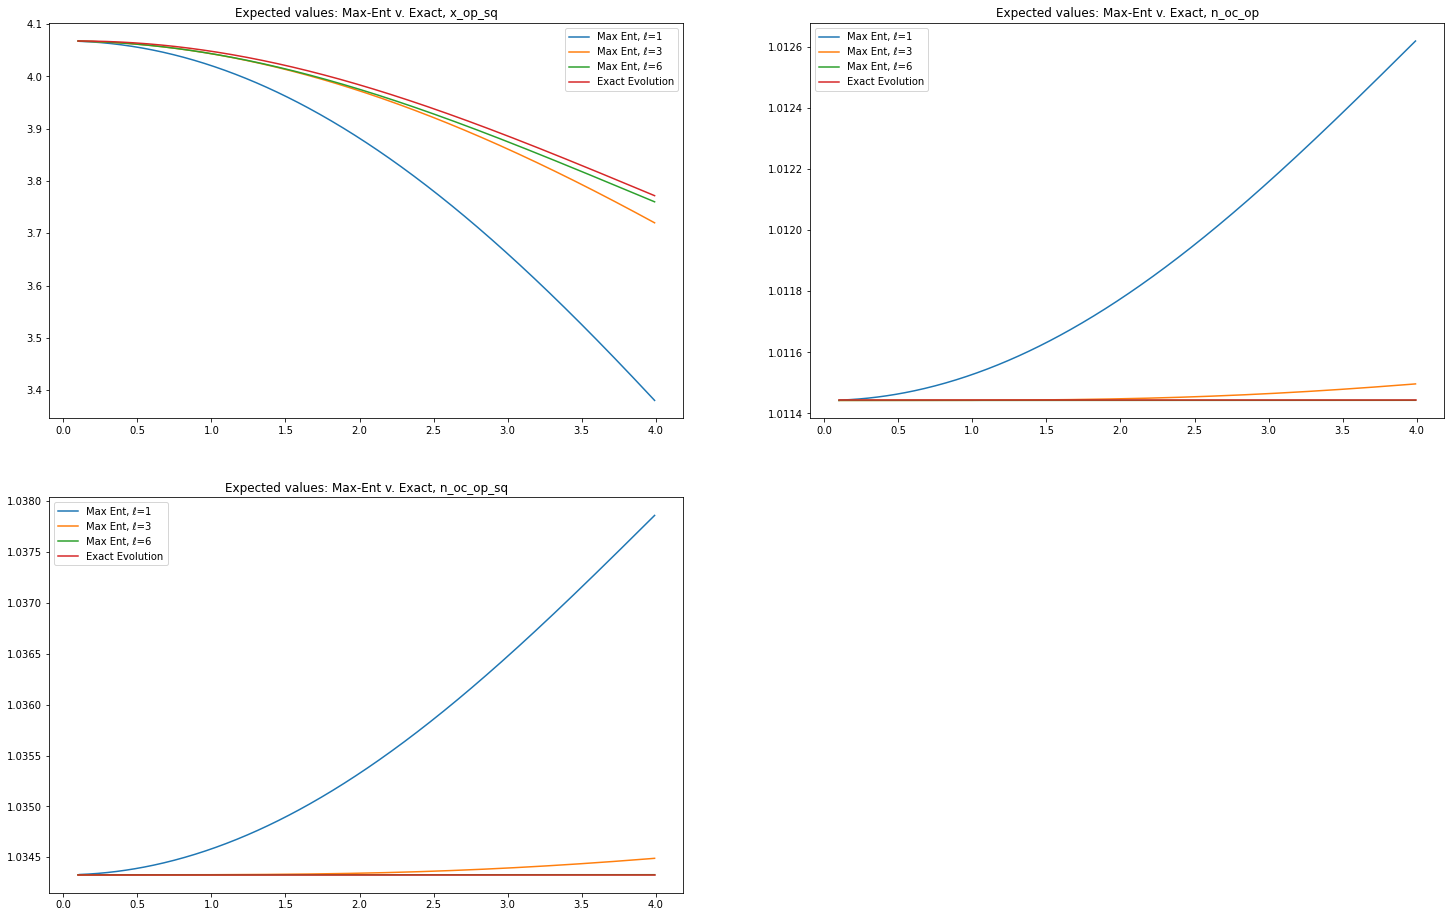

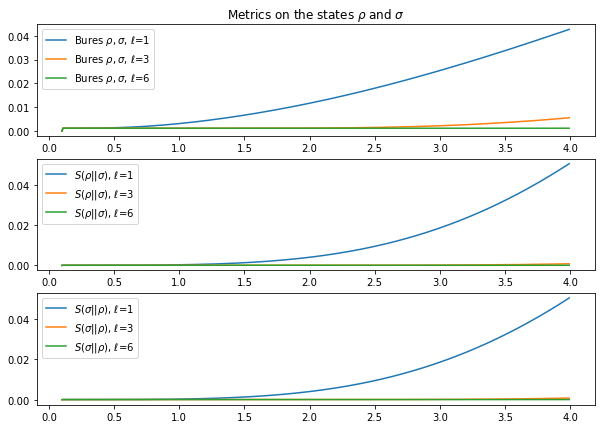

In [134]:
ts = np.linspace(1e-1, 4., 500)

resultados = HBProjEv.multiple_MaxEnt_evs(Hamiltonian = H_H, fixed_ops_list = calB_basis_0,
                                                    rho_ref = rho_ref, 
                                                    range_HierarchBases_dims = depth_parameters, 
                                                     temp_ref = temp_ref, temp_rho = temp,
                                                     generating_operator = cl_ops["x_op"],
                                                     init_coeff_list = all_coeff_list,
                                                     timespan = ts, label_ops = subset_label_ops,
                                                     observables = list(subset_of_observables.values()),
                                                     rho_ref_equal_rho0 = False)

evs_visz_tools.plot_exact_v_proj_ev_avgs_multiple(labels = subset_label_ops,
                                                 timespan = ts,
                                                 no_cols_desired = 2,
                                                 multiple_evolutions = resultados,
                                                 range_of_temps_or_dims = depth_parameters,
                                                  plot_var_HierarchBases_dim = True)

metrics = mat_ansys.exact_v_proj_ev_matrix_metrics_multiple(timespan = ts,
                                                            range_of_temps_or_dims = depth_parameters,
                                                                  multiple_evolutions = resultados,
                                                plot_var_HierarchBases_dim = True)

evs_visz_tools.plot_exact_v_proj_ev_metrics_multiple(timespan = ts,
                                                     range_of_temps_or_dims = depth_parameters,
                                                     metric_local = metrics, cols = 1,
                                         plot_var_HierarchBases_dim = True)

In [135]:
resultados["res_exact"]['res_exact_MaxEnt2'].expect[2]
resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["Avgs"]

[array([4.067, 4.067, 4.067, ..., 3.762, 3.761, 3.7600000000000002]),
 array([1.0110000000000001, 1.0110000000000001, 1.0110000000000001, ..., 1.0110000000000001, 1.0110000000000001,
        1.0110000000000001]),
 array([1.034, 1.034, 1.034, ..., 1.034, 1.034, 1.034])]

In [136]:
### Test: 
rho0_HB0 = resultados["all_init_configs"]["init_configs_MaxEnt0"]["rho0"]
rho0_HB1 = resultados["all_init_configs"]["init_configs_MaxEnt1"]["rho0"]
rho0_HB2 = resultados["all_init_configs"]["init_configs_MaxEnt2"]["rho0"]
rho0_exact = resultados["res_exact"]['res_exact_MaxEnt2'].states[0]

print(r'Are all initial states, $\rho_0$, equal for all evolutions?')
rho0_HB0 == rho0_HB1 == rho0_HB2 == rho0_exact

Are all initial states, $\rho_0$, equal for all evolutions?


True

In [137]:
n_oc_op_HB0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["Avgs"][1]
n_oc_op_HB1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["Avgs"][1]
n_oc_op_HB2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["Avgs"][1]
n_oc_op_exact = resultados["res_exact"]['res_exact_MaxEnt2'].expect[1]
res_n_evs = [n_oc_op_exact[:-1], n_oc_op_HB0, n_oc_op_HB1, n_oc_op_HB2]

n_oc_op_sq_HB0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["Avgs"][2]
n_oc_op_sq_HB1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["Avgs"][2]
n_oc_op_sq_HB2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["Avgs"][2]
n_oc_op_sq_exact = resultados["res_exact"]['res_exact_MaxEnt2'].expect[2]
res_n_sq_evs = [n_oc_op_sq_exact, n_oc_op_sq_HB0, n_oc_op_sq_HB1, n_oc_op_sq_HB2]

In [138]:
n_oc_std_exact = [(n_oc_op_sq_exact[m] - n_oc_op_exact[m]**2) for m in range(len(n_oc_op_sq_exact))]
n_oc_std_HB0 = [(n_oc_op_sq_HB0[m] - n_oc_op_HB0[m]**2) for m in range(len(n_oc_op_sq_HB0))]
n_oc_std_HB1 = [(n_oc_op_sq_HB1[m] - n_oc_op_HB1[m]**2) for m in range(len(n_oc_op_sq_HB1))]
n_oc_std_HB2 = [(n_oc_op_sq_HB2[m] - n_oc_op_HB2[m]**2) for m in range(len(n_oc_op_sq_HB2))]

n_oc_std_all_evs = [n_oc_std_exact[:-1], n_oc_std_HB0, n_oc_std_HB1, n_oc_std_HB2]
labels = [", Ex", ", ℓ=1", ", ℓ=3", ", ℓ=6"]

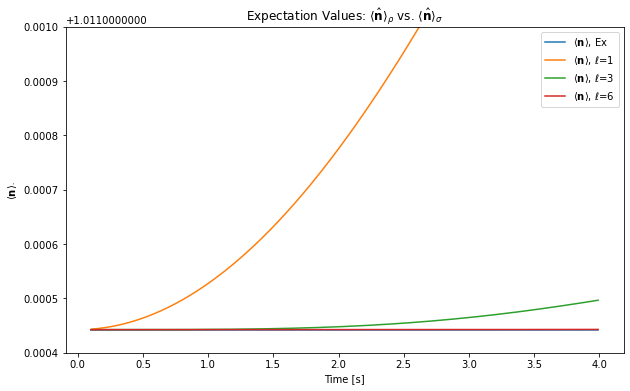

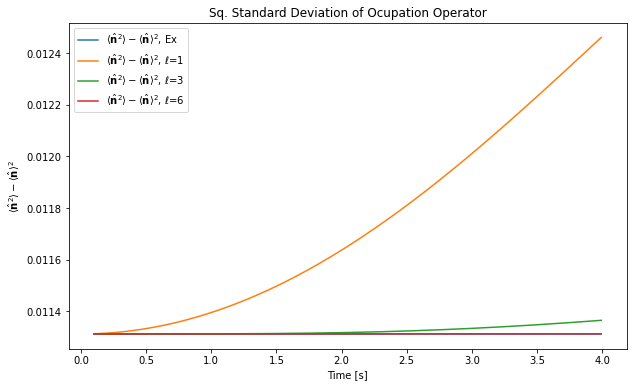

In [144]:
fig0, ax0 = plt.subplots(figsize=(10,6))

for n in range(len(n_oc_std_all_evs)):
    plt.plot(ts[:-1], res_n_evs[n], label = r'$\langle {\bf n} \rangle$' + labels[n])

plt.ylim(1.0114, 1.012)
ax0.legend(loc=0)
ax0.set_xlabel(r'Time [s]')
ax0.set_ylabel(r'$\langle {\bf n} \rangle_{\cdot}$')
ax0.set_title(r'Expectation Values: $\langle \hat{{\bf n}} \rangle_{\rho} $ vs. $\langle \hat{{\bf n}} \rangle_{\sigma}$');

fig, ax = plt.subplots(figsize=(10,6))

for n in range(len(n_oc_std_all_evs)):
    plt.plot(ts[:-1], n_oc_std_all_evs[n], label = r'${\langle \hat{{\bf n}}^2 \rangle - \langle \hat{{\bf n}}\rangle^2}$' + labels[n])

ax.legend(loc=0)
#plt.ylim(0.0113, 0.00114)
ax.set_xlabel(r'Time [s]')
ax.set_ylabel(r'${\langle \hat{{\bf n}}^2 \rangle - \langle \hat{{\bf n}}\rangle^2}$')
ax.set_title(r'Sq. Standard Deviation of Ocupation Operator');

## FFT de los observables XX

Processing step:  1  and hierarchical basis of ℓ=  1
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
basis_incursive_len 6
    |▼| 2. using a base of size  6
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the same cardinalities.
    |▼| 5. ProjEv Dynamics Succesfully Concluded.
    |▼| 6b. Exact Dynamics not to be computed. Skipped.
    |▼| 7b. No Plots to process.
    |▼| 8. Data Stored. Evolutions concluded. 

Processing step:  2  and hierarchical basis of ℓ=  3
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
basis_incursive_len 8
    |▼| 2. using a base of size  8
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the

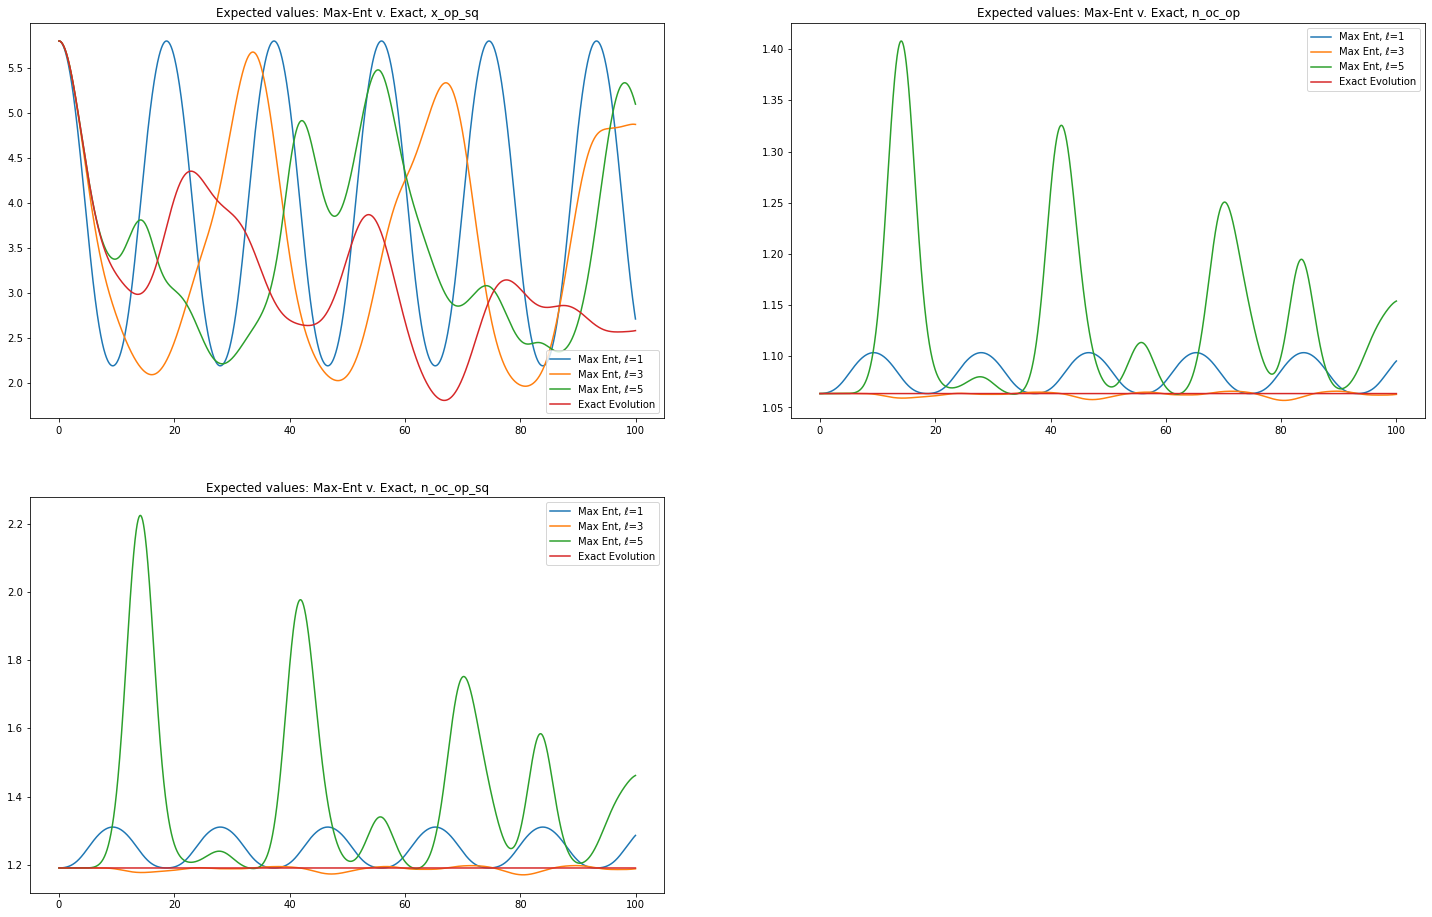

In [30]:
ts = np.linspace(1e-5, 100.0, 6000)
fixed_ops_list = calB_basis_0

resultados = HBProjEv.multiple_MaxEnt_evs(Hamiltonian = H_H, fixed_ops_list = calB_basis_0,
                                                    rho_ref = rho_ref, 
                                                    range_HierarchBases_dims = depth_parameters, 
                                                     temp_ref = temp_ref, temp_rho = temp,
                                                     generating_operator = cl_ops["x_op"],
                                                     init_coeff_list = all_coeff_list,
                                                     timespan = ts, label_ops = subset_label_ops,
                                                     observables = list(subset_of_observables.values()),
                                                     rho_ref_equal_rho0 = False)

evs_visz_tools.plot_exact_v_proj_ev_avgs_multiple(labels = subset_label_ops,
                                                 timespan = ts,
                                                 no_cols_desired = 2,
                                                 multiple_evolutions = resultados,
                                                 range_of_temps_or_dims = depth_parameters,
                                                  plot_var_HierarchBases_dim = True)

C:\Users\tomas\PhD Physics\2nd Year\Max_Ent_restricted_evs\Github Repo Docu\a_matrix_analysis_lib.py:366: RuntimeWarning: invalid value encountered in arccos
  return  np.arccos(fidelity)/np.pi


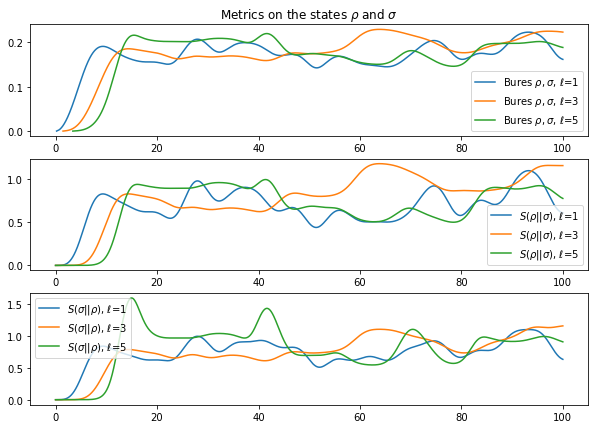

In [31]:
metrics = mat_ansys.exact_v_proj_ev_matrix_metrics_multiple(timespan = ts,
                                                            range_of_temps_or_dims = depth_parameters,
                                                                  multiple_evolutions = resultados,
                                                plot_var_HierarchBases_dim = True)

evs_visz_tools.plot_exact_v_proj_ev_metrics_multiple(timespan = ts,
                                                     range_of_temps_or_dims = depth_parameters,
                                                     metric_local = metrics, cols = 1,
                                         plot_var_HierarchBases_dim = True)

In [32]:
avsg_xop_sq_exact = resultados["res_exact"]['res_exact_MaxEnt2'].expect[0][:-1]
avgs_xop_sq_HB0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["Avgs"][0]
avgs_xop_sq_HB1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["Avgs"][0]
avgs_xop_sq_HB2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["Avgs"][0]

avsg_xop_sq_exact = resultados["res_exact"]['res_exact_MaxEnt2'].expect[0][:-1]
avgs_xop_sq_HB0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["Avgs"][0]
avgs_xop_sq_HB1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["Avgs"][0]
avgs_xop_sq_HB2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["Avgs"][0]

freq_fft = np.fft.fftfreq(ts.shape[-1])
#freq_plot = [freq_fft[t] for t in range(len(freq_fft)) if (t <= -0.2 or t >= 0.2)]
freq_plot = freq_fft
freqs_fft_avgs_x_op_exact = np.fft.fft(avsg_xop_sq_exact)[1:]
freqs_fft_avgs_x_op_hb1 = np.fft.fft(avgs_xop_sq_HB0)[1:]
freqs_fft_avgs_x_op_hb3 = np.fft.fft(avgs_xop_sq_HB1)[1:]
freqs_fft_avgs_x_op_hb6 = np.fft.fft(avgs_xop_sq_HB2)[1:]

freqs_fft_avgs_all = [freqs_fft_avgs_x_op_hb1, freqs_fft_avgs_x_op_hb3, freqs_fft_avgs_x_op_hb6]

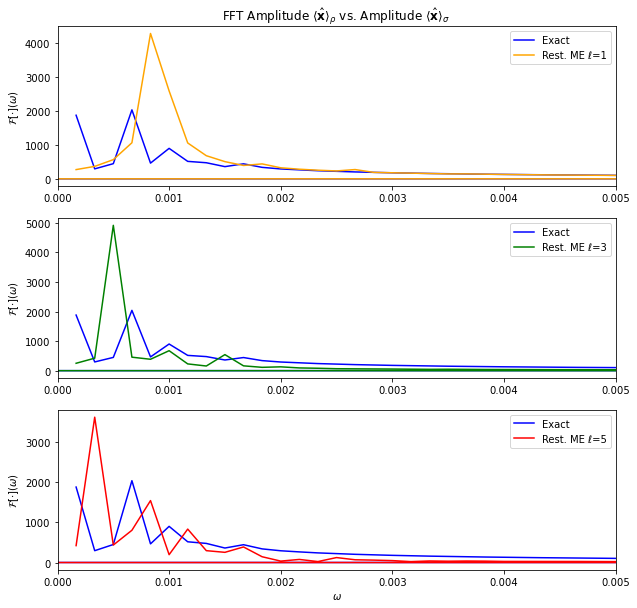

In [33]:
HB_dims = [1,3,5]
Tot = 3; Cols = 1
Rows = Tot // Cols 
if Tot % Cols != 0:
    Rows += 1
Position = range(1,Tot + 1)
fig = plt.figure(figsize=(10, 10))
colors = ["orange", "green", "red"]

for k in range(Tot):
    if k == 1:
        ax.set_title(r'FFT Amplitude $\langle \hat{\bf x} \rangle_{\rho}$ vs. Amplitude $\langle \hat{\bf x} \rangle_{\sigma}$')  
    ax = fig.add_subplot(Rows, Cols, Position[k])
    ax.plot(freq_plot[1:][:-1], abs(freqs_fft_avgs_x_op_exact.real + 1j * freqs_fft_avgs_x_op_exact.imag), color = "blue", label = "Exact")
    ax.plot(freq_plot[1:][:-1], abs(freqs_fft_avgs_all[k].real + 1j * freqs_fft_avgs_all[k].imag), color = colors[k], label = "Rest. ME ℓ=" + str(HB_dims[k]))
    plt.ylabel(r'${\cal F} [\cdot](\omega)$')
    if k == 2: 
        plt.xlabel(r'$\omega$')
    plt.xlim(0, .005)
    ax.legend(loc=0)